<a href="https://colab.research.google.com/github/cbrodman/dl_course_2022/blob/main/17_faces_regression_CBr_save.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Age Regression with Tensorflow Probability

In this notebook you will learn how work with TFP. You will set up regression models that are able to output a gaussian conditional probability distribution. You will define different models with Keras and the Tensorflow probability framework and optimize the negative log likelihood (NLL). You will model the conditional probability distribution as a Normal distribution with a constant and flexible standart deviation $\sigma$. The mean $\mu$ of the CPD will depend non-linearly on the input. You will compare the NLL of the two models with the constant and felxible standart deviation $\sigma$. As input data you will use images of faces and you will try to predict the conditional probability distribution of their age.

**Dataset:** 
You work with a the UTKFace dataset. It is a large dataset with long age span (range from 0 to 116 years old). The dataset consists of over 20,000 face images with annotations of age, gender, and ethnicity. The data is already preprcessed and rescaled (80x80 pixels) so you can work with it. You will only use the information of the age.

**Content:**
* Load and and split the dataset 
* Fit a model with keras and TFP that models the CPD with a non-linear mean $\mu$ and a constant standart deviation $\sigma$ .
* Fit a model with keras and TFP that models the CPD with a non-linear mean $\mu$ and a flexible standart deviation $\sigma$ with TFP.
* Compare the two models based on the NLL loss on the test dataset.


In [23]:
!pip install tensorflow==2.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 421.8 MB 26 kB/s 
     |████████████████████████████████| 3.8 MB 54.2 MB/s 
     |████████████████████████████████| 26.1 MB 450 kB/s 
     |████████████████████████████████| 50 kB 1.1 MB/s 
     |████████████████████████████████| 448 kB 64.4 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=bea9bffcdbfdd1a949a6e2e32dca0c3c0bfb2d134a4ad3229d6098ecf1241b31
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      

In [1]:
!pip install tensorflow_probability==0.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 5.3 MB/s 
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 1.3.0
    Uninstalling cloudpickle-1.3.0:
      Successfully uninstalled cloudpickle-1.3.0
  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.16.0
    Uninstalling tensorflow-probability-0.16.0:
      Successfully uninstalled tensorflow-probability-0.16.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gym 0.17.3 requires cloudpickle<1.7.0,>=1.2.0, but you have cloudpickle 1.1.1 which is incompatible.


#### Imports

In [2]:
import numpy as np
import urllib
import os
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import tensorflow as tf
%matplotlib inline
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation, Dropout, Input, Concatenate
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras import optimizers
tfd = tfp.distributions

from sklearn.metrics import mean_squared_error
np.random.seed(99)

In [3]:
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)

TFP Version 0.8.0
TF  Version 2.1.0


#### Loading the data, if it is not loaded

In [8]:
if not os.path.isfile('X_faces.npy'):
    urllib.request.urlretrieve(
    "https://www.dropbox.com/s/5m7nmebpjysqtus/X_faces.npy?dl=1",
    "X_faces.npy")

if not os.path.isfile('Y_age.npy'):
    urllib.request.urlretrieve(
    "https://www.dropbox.com/s/flpyvgdqoatdw0g/Y_age.npy?dl=1",
    "Y_age.npy")


In [9]:
X=np.load("X_faces.npy")
Y=np.load("Y_age.npy")

#### Splitting the data into train, val and test dataset

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=201)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=34)

In [7]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(10642, 80, 80, 3)
(5242, 80, 80, 3)
(7824, 80, 80, 3)


#### Looking at the image data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


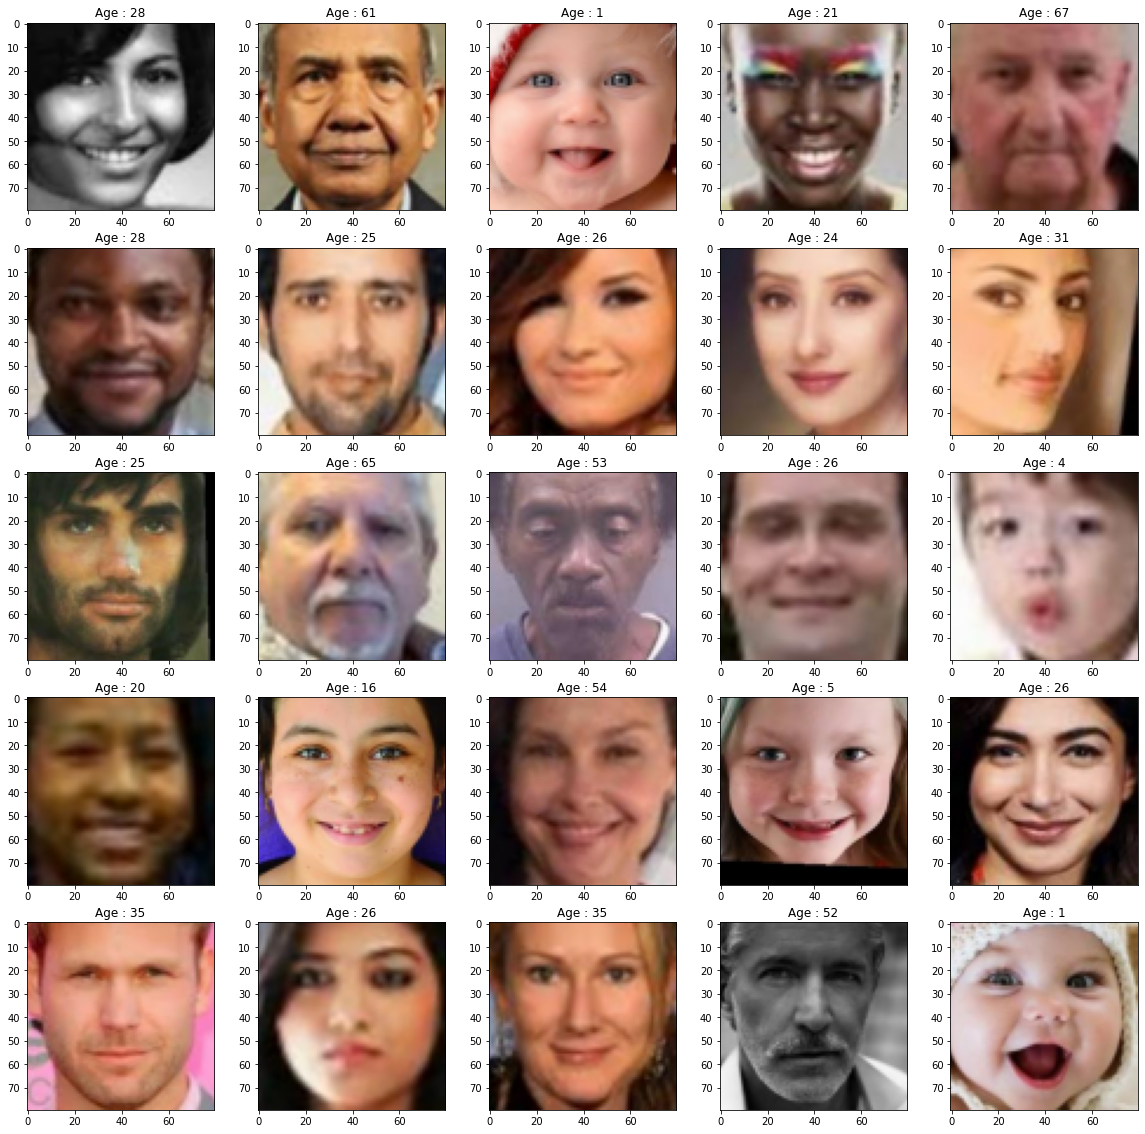

In [11]:
plt.figure(figsize=(20,20))
for i in range(0,25):
    plt.subplot(5,5,i+1)
    plt.imshow(X_train[i])
    plt.title("Age : "+ np.str(y_train[i]))

#### Normalize the data

In [12]:
X_train=X_train/255
X_val=X_val/255
X_test=X_test/255

In [13]:
X_train = np.array(X_train,dtype="float32")
X_val = np.array(X_val,dtype="float32")
X_test = np.array(X_test,dtype="float32")

y_train = np.array(y_train,dtype="float32")
y_val = np.array(y_val,dtype="float32")
y_test = np.array(y_test,dtype="float32")

#### Looking at the distribution of the target variable

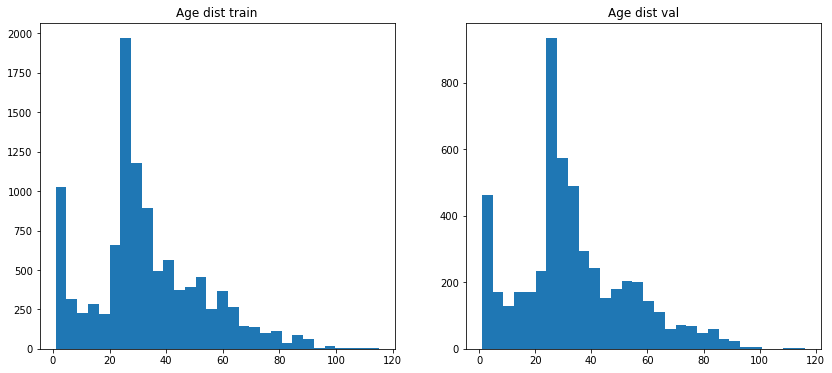

In [14]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.hist(y_train,bins=30)
plt.title("Age dist train")
plt.subplot(1,2,2)
plt.hist(y_val,bins=30)
plt.title("Age dist val")
plt.show()


## Fit a regression model with constant variance
In the next cells you will define and fit a model on the face images. You will use a CNN to model the $\mu$ parameter of  a gaussian conditional probability distribution, the $\sigma$ will be constant for all inputs. For the loss we use the NLL. Note that we will use the trick with a second input that will be all ones, to model the constant $\sigma$.

In [15]:
kernel_size = (3, 3)
pool_size = (2, 2)

In [16]:
def NLL(y, distr):
  return -distr.log_prob(y) 

def my_dist(params): 
  return tfd.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2]))# both parameters are learnable

input1 = Input(shape=(80,80,3))
input2 = Input(shape=(1,))
x = Convolution2D(16,kernel_size,padding='same',activation="relu")(input1)
x = Convolution2D(16,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)

x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)

x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)

x = Flatten()(x)
x = Dense(500,activation="relu")(x) # 500 neurons
x = Dropout(0.3)(x)
x = Dense(50,activation="relu")(x) # 50 neurons
x = Dropout(0.3)(x)
out1 = Dense(1)(x) # one fixed value with 1 sigma
out2 = Dense(1)(input2) # one fixed value with 1 lambda
params = Concatenate()([out1,out2]) 
dist = tfp.layers.DistributionLambda(my_dist)(params) #

model_const_sd = Model(inputs=[input1,input2], outputs=dist) ## use a trick with two inputs, input2 is just ones
model_const_sd.compile(tf.keras.optimizers.Adam(), loss=NLL) 

In [18]:
# train the model

if os.path.exists('./FacesModel.h5'):
    print("Loading model")
   # model = tf.keras.models.load_model('./FacesModel.h5', compile=False)
    model_const_sd.compile(tf.keras.optimizers.Adam(), loss=NLL) 
else:
    history=model_const_sd.fit([X_train,np.expand_dims(np.ones(len(X_train)),1)], y_train, 
                    batch_size=16, 
                    epochs=1,
                    verbose=1, 
                    validation_data=([X_val,np.expand_dims(np.ones(len(X_val)),1)], y_val)
                  )
    history.model.save('./FacesModel.h5')

Loading model


In [19]:
model_const_sd_mean = Model(inputs=[input1,input2], outputs=dist.mean())
model_const_sd_sd = Model(inputs=[input1,input2], outputs=dist.stddev())

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

#### Look at the predicted mean of the CPD on the testset


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


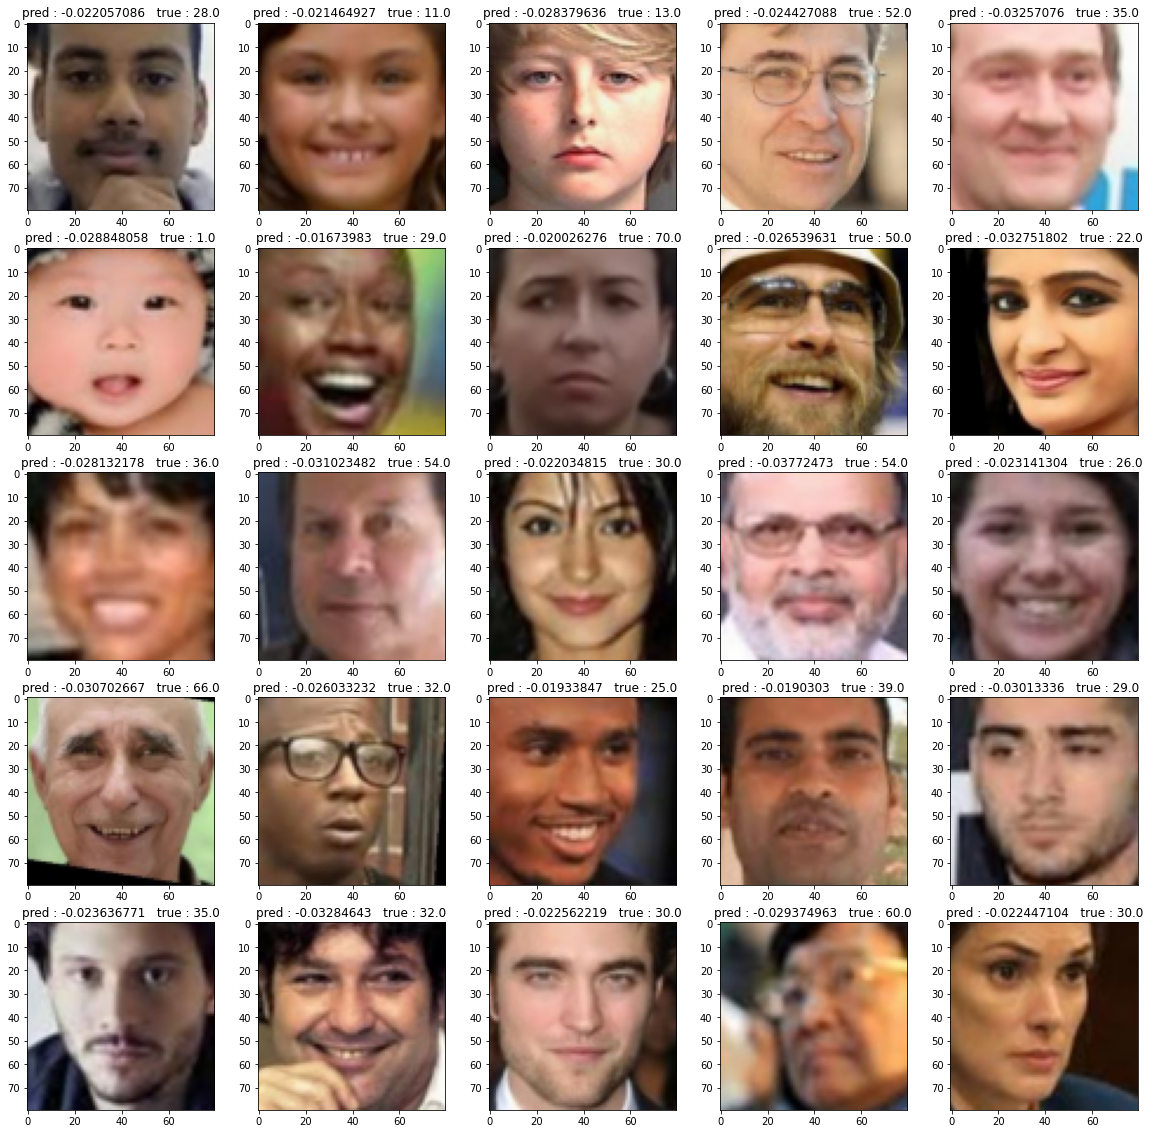

In [20]:
plt.figure(figsize=(20,20))
for i in range(0,25):
    plt.subplot(5,5,i+1)
    plt.imshow(X_test[i])
    plt.title("pred : "+ np.str(model_const_sd_mean.predict([X_test[i:i+1],np.expand_dims(np.ones(len(X_test[i:i+1])),1)])[0][0]) + "   true : "+ np.str(y_test[i]))

#### Look at the predicted mean and the predicted sigma of the CPD on the testset


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


[[-0.02205709]]
[[0.70101786]]


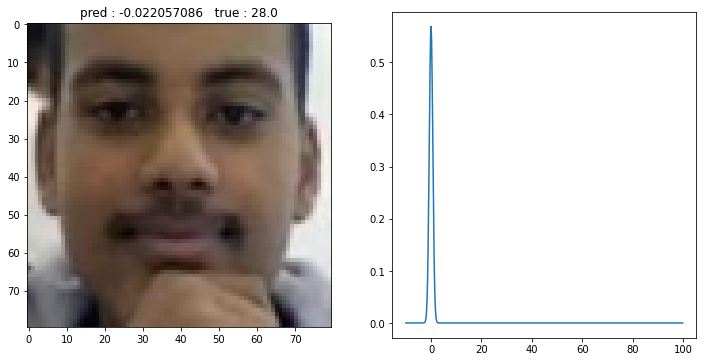

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


[[-0.02146493]]
[[0.70101786]]


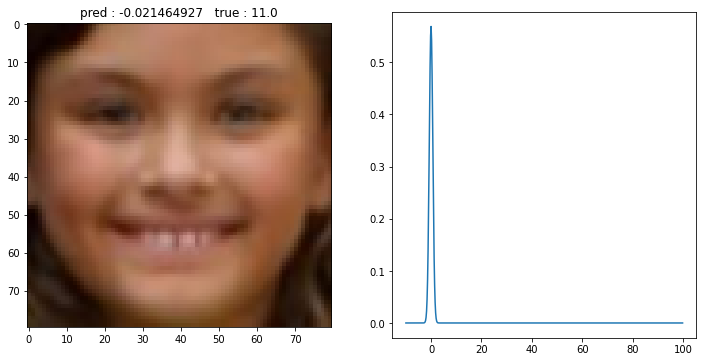

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


[[-0.02837964]]
[[0.70101786]]


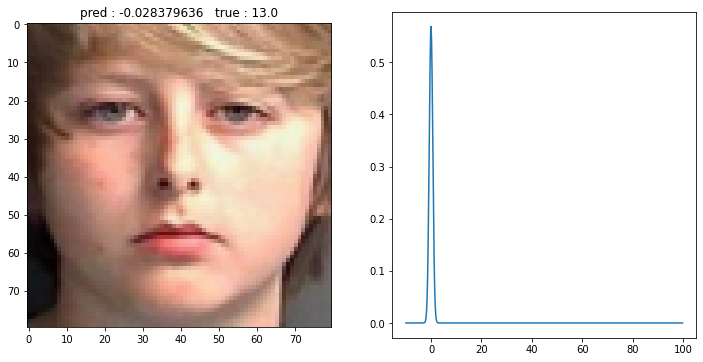

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


[[-0.02442709]]
[[0.70101786]]


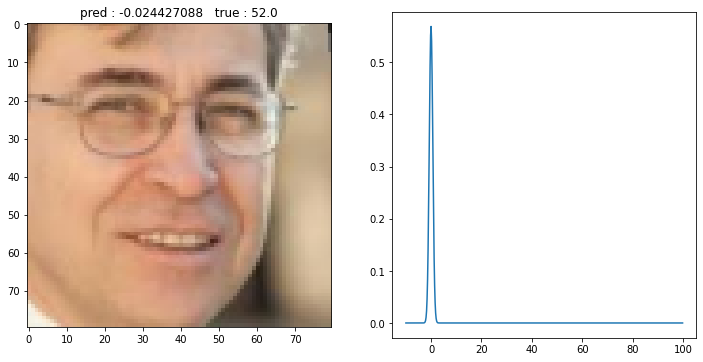

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


[[-0.03257076]]
[[0.70101786]]


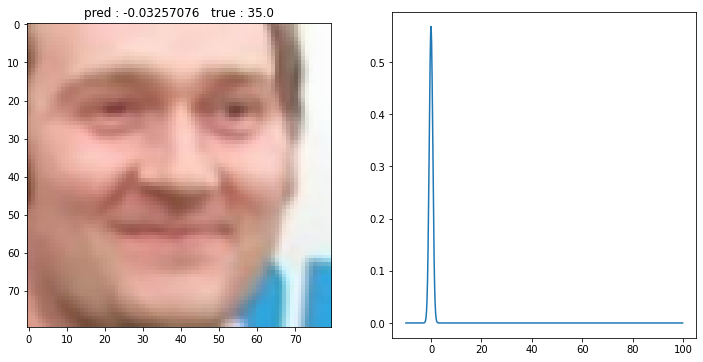

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


[[-0.02884806]]
[[0.70101786]]


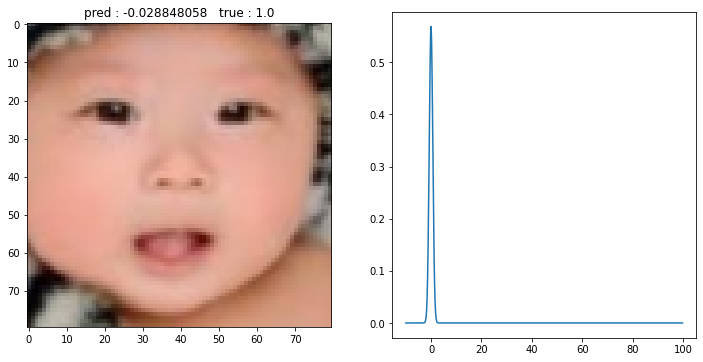

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


[[-0.01673983]]
[[0.70101786]]


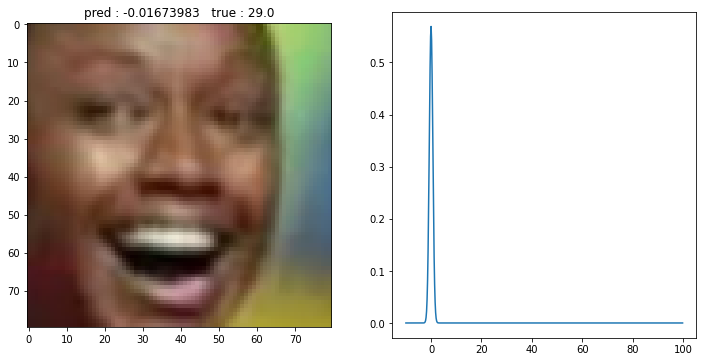

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


[[-0.02002628]]
[[0.70101786]]


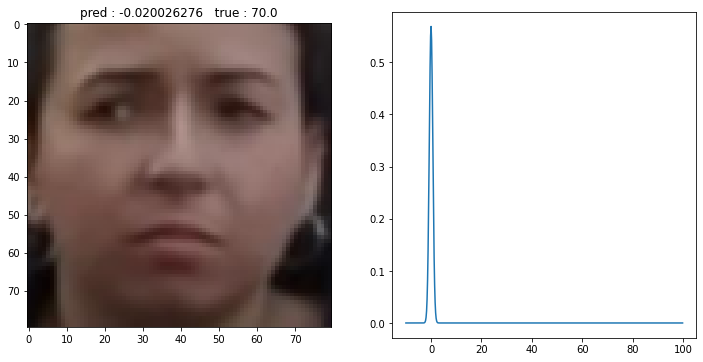

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


[[-0.02653963]]
[[0.70101786]]


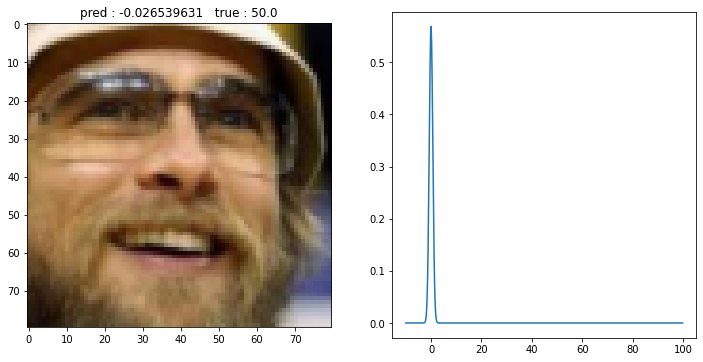

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


[[-0.0327518]]
[[0.70101786]]


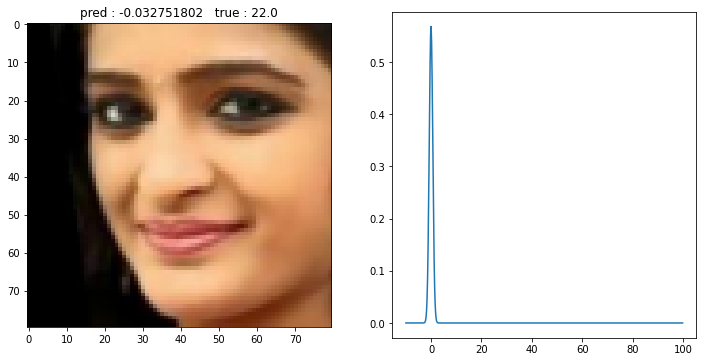

In [21]:
for i in range(0,10):
  plt.figure(figsize=(12,6))
  plt.subplot(1,2,1)
  plt.imshow(X_test[i])
  plt.title("pred : "+ np.str(model_const_sd_mean.predict([X_test[i:i+1],np.expand_dims(np.ones(len(X_test[i:i+1])),1)])[0][0]) + "   true : "+ np.str(y_test[i]))
  print(model_const_sd_mean.predict([X_test[i:i+1],np.expand_dims(np.ones(len(X_test[i:i+1])),1)]))
  print(model_const_sd_sd.predict([X_test[i:i+1],np.expand_dims(np.ones(len(X_test[i:i+1])),1)]))
  d = tfd.Normal(loc=model_const_sd_mean.predict([X_test[i:i+1],np.expand_dims(np.ones(len(X_test[i:i+1])),1)]), scale=model_const_sd_sd.predict([X_test[i:i+1],np.expand_dims(np.ones(len(X_test[i:i+1])),1)]))           #A
  plt.subplot(1,2,2)
  plt.plot(np.arange(-10,100,0.2),d.prob(np.arange(-10,100,0.2))[0])
  plt.show()

## Fit a regression model with felxible variance
In the next cells you will afain define and fit a model on the face images. You will use a CNN to model the mu parameter of a gaussian conditional probability distribution, but this time the sigma will not be constant for all inputs. Every iamge will be able to have a different sigma. For the loss we use the NLL.

In [22]:
def NLL(y, distr):
  return -distr.log_prob(y) 

def my_dist(params): 
  return tfd.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2]))# both parameters are learnable

inputs = Input(shape=(80,80,3))
x = Convolution2D(16,kernel_size,padding='same',activation="relu")(inputs)
x = Convolution2D(16,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)

x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)

x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)

x = Flatten()(x)
x = Dense(500,activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(50,activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(2)(x)
dist = tfp.layers.DistributionLambda(my_dist)(x) 

model_flex = Model(inputs=inputs, outputs=dist)
model_flex.compile(tf.keras.optimizers.Adam(), loss=NLL) 


In [23]:
# train the model
history=model_flex.fit(X_train, np.array(y_train,dtype="float32"), 
                  batch_size=16, 
                  epochs=40,
                  verbose=1, 
                  validation_data=(X_val, np.array(y_val,dtype="float32")))


Train on 10642 samples, validate on 5242 samples
Epoch 1/40
10642/10642 [==============================] - 7s 612us/sample - loss: 15.5278 - val_loss: 4.4922
Epoch 2/40
10642/10642 [==============================] - 5s 505us/sample - loss: 4.6527 - val_loss: 4.5159
Epoch 3/40
10642/10642 [==============================] - 6s 533us/sample - loss: 4.6114 - val_loss: 4.5837
Epoch 4/40
10642/10642 [==============================] - 6s 528us/sample - loss: 4.5545 - val_loss: 4.3941
Epoch 5/40
10642/10642 [==============================] - 6s 576us/sample - loss: 4.5400 - val_loss: 4.3941
Epoch 6/40
10642/10642 [==============================] - 6s 602us/sample - loss: 4.4707 - val_loss: 4.3047
Epoch 7/40
10642/10642 [==============================] - 6s 597us/sample - loss: 4.3566 - val_loss: 4.1862
Epoch 8/40
10642/10642 [==============================] - 6s 605us/sample - loss: 4.3211 - val_loss: 4.1972
Epoch 9/40
10642/10642 [==============================] - 6s 601us/sample - loss: 4.25

In [ ]:
model_mean = Model(inputs=inputs, outputs=dist.mean())
model_sd = Model(inputs=inputs, outputs=dist.stddev())

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

#### Look at the predicted mean of the CPD on the testset


In [ ]:
plt.figure(figsize=(20,20))
for i in range(0,25):
    plt.subplot(5,5,i+1)
    plt.imshow(X_test[i])
    plt.title("pred : "+ np.str(model_mean.predict(X_test[i:i+1])[0][0]) + "   true : "+ np.str(y_test[i]))

#### Look at the predicted mean and the predicted sigma of the CPD on the testset


In [ ]:
for i in range(0,10):
  plt.figure(figsize=(12,6))
  plt.subplot(1,2,1)
  plt.imshow(X_test[i])
  plt.title("pred : "+ np.str(model_mean.predict(X_test[i:i+1])[0][0]) + "   true : "+ np.str(y_test[i]))
  print(model_mean.predict(X_test[i:i+1]))
  print(model_sd.predict(X_test[i:i+1]))
  d = tfd.Normal(loc=model_mean.predict(X_test[i:i+1]), scale=model_sd.predict(X_test[i:i+1]))           #A
  plt.subplot(1,2,2)
  plt.plot(np.arange(-10,100,0.2),d.prob(np.arange(-10,100,0.2))[0])
  plt.show()

#### Exercise
Calculate the MSE the RMSE and the NLL for both models on the testset.  
Which model would you prefer in practice and why?  



In [ ]:
### Your code here